In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from hurst import compute_Hc
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.optimize as spop
from sklearn.linear_model import LinearRegression
from statistics import mean
import json
import ta


In [24]:

with open('stat_pairs.json', 'r') as f:
    selected_pairs_3 = json.load(f)

In [25]:
plt.style.use('seaborn')
sns.set_style('darkgrid')
prices = pd.read_csv('etfs.csv')
#prices.columns
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.set_index('Date')
prices = prices.dropna(axis=1)
prices.head()
returns = np.log(prices).diff().dropna()

In [26]:
P_VALUE_THRESHOLD = 0.05
HURST_THRESHOLD = 0.5
TRADING_PERIOD = 253

In [27]:
form_start = '2011-01-01'
form_end = '2016-12-31'
trade_start = '2017-01-01'
trade_end = '2019-12-31'

prices_form = prices[form_start:form_end]
prices_trade = prices[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

In [28]:
start = trade_start
end = trade_end
fee = 0
window = 252
t_threshold = -2.5

In [29]:
#helper funcs
def parse_pair(pair):
    s1 = pair[:pair.find('-')]
    s2 = pair[pair.find('-')+1:]
    return s1,s2

def calculate_metrics(cumret):
    
        total_return = (cumret[-1] - cumret[0])/cumret[0]
        apr = (1+total_return)**(252/len(cumret)) - 1
        rets = pd.DataFrame(cumret).pct_change()
        sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
        highwatermark=np.zeros(cumret.shape)
        drawdown=np.zeros(cumret.shape)
        drawdownduration=np.zeros(cumret.shape)
        for t in np.arange(1, cumret.shape[0]):
            highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
            drawdown[t]=cumret[t]/highwatermark[t]-1
            if drawdown[t]==0:
                drawdownduration[t]=0
            else:
                drawdownduration[t]=drawdownduration[t-1]+1
        maxDD=np.min(drawdown)
        maxDDD=np.max(drawdownduration)
    
        return total_return, sharpe, maxDD

In [52]:
import numpy as np
import pandas as pd
import scipy.optimize as spop
import statsmodels.api as sm
from ta.volatility import BollingerBands

def baseline(selected_pairs_3, returns_form, trade_start, trade_end):
    data = returns_form
    start = trade_start
    end = trade_end
    fee = 0
    window = 252
    t_threshold = 2
    
    # initializing arrays
    gross_returns = np.array([])
    net_returns = np.array([])
    t_s = np.array([])
    
    stock1, stock2 = parse_pair(selected_pairs_3)
    data = data[start:end]
    
    # moving through the sample
    for t in range(window, len(data)):
        bbands = BollingerBands(close=data[stock2][t-window:t+1])
        upper_band = bbands.bollinger_hband_indicator()
        lower_band = bbands.bollinger_lband_indicator()
        moving_avg = bbands.bollinger_mavg()
        
        if data[stock2][t] > upper_band[t]:
            signal = -1
        elif data[stock2][t] < lower_band[t]:
            signal = 1
        else:
            signal = 0
            
        gross_return = signal * returns_form[stock2][t] - signal * returns_form[stock1][t]
        fees = fee * abs(signal)
        net_return = gross_return - fees
        gross_returns = np.append(gross_returns, gross_return)
        net_returns = np.append(net_returns, net_return)
        
    total_trades = len(gross_returns)
    winning_trades = len(gross_returns[gross_returns > 0])
    losing_trades = len(gross_returns[gross_returns < 0])
    hit_ratio = winning_trades / total_trades if total_trades > 0 else np.nan
    expected_return = np.mean(gross_returns) if total_trades > 0 else np.nan
    expected_loss = np.mean(gross_returns[gross_returns < 0]) if losing_trades > 0 else np.nan
    roi = np.nansum(net_returns) / 100 if total_trades > 0 else np.nan
    
    return hit_ratio, expected_return, expected_loss, roi


In [54]:
def baseline(selected_pairs_3, returns_form, trade_start,trade_end):
    data = returns_form
    print(selected_pairs_3)
    
    start = trade_start
    end = trade_end
    fee = 0
    window = 252
    t_threshold = -2.5
    
    #initialising arrays
    gross_returns = np.array([])
    net_returns = np.array([])
    t_s = np.array([])
    winning_trades = 0
    losing_trades = 0
    total_trades = 0
    total_returns = 0
    expected_return = 0
    expected_loss = 0
    roi = 0
    
    stock1, stock2 = parse_pair(selected_pairs_3)
    data = data[start:end]

    #moving through the sample
    for t in range(window, len(data)):
        #defining the unit root function: stock2 = a + b*stock1
        def unit_root(b):
            a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
            fair_value = a + b*data[stock1][t-window:t]
            diff = np.array(fair_value - data[stock2][t-window:t])
            diff_diff = diff[1:] - diff[:-1]
            reg = sm.OLS(diff_diff, diff[:-1])
            res = reg.fit()
            return res.params[0]/res.bse[0]

        #optimising the cointegration equation parameters
        res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method='Nelder-Mead')
        t_opt = res1.fun
        b_opt = float(res1.x)
        a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])

        #simulating trading
        fair_value = a_opt + b_opt*data[stock1][t]
        if t == window:
            old_signal = 0
        if t_opt > t_threshold:
            signal = 0
            gross_return = 0
        else:
            signal = np.sign(fair_value - data[stock2][t])
            gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
            if gross_return > 0:
                winning_trades += 1
            elif gross_return < 0:
                losing_trades += 1
            total_returns += gross_return

        fees = fee*abs(signal - old_signal)
        net_return = gross_return - fees
        gross_returns = np.append(gross_returns, gross_return)
        net_returns = np.append(net_returns, net_return)
        t_s = np.append(t_s, t_opt)
        old_signal = signal
        total_trades += 1
    
    # calculate metrics
    hit_ratio = winning_trades / max(total_trades, 1)
    expected_return = total_returns / max(winning_trades, 1)
    expected_loss = -total_returns / max(losing_trades, 1)
    roi = 100 * np.prod(net_returns + 1)
    
    return hit_ratio, expected_return, expected_loss, roi
hit_ratio_arr = []
expected_return_arr = []
expected_loss_arr = []
#hr = []
roi_arr = []




In [53]:
hit_ratio_arr = []
expected_return_arr = []
expected_loss_arr = []
#hr = []
roi_arr = []


for pair in selected_pairs_3:
    try:
        x = baseline(pair, prices_trade, trade_start,trade_end)
        hit_ratio_arr.append(x[0])
        expected_return_arr.append(x[1])
        expected_loss_arr.append(x[2])
        roi_arr.append(x[3])
    except IndexError as e:
        print(f"Error for pair {pair}: {e}")


Error for pair ACWI-SCHA: index 253 is out of bounds for axis 0 with size 253
Error for pair ACWI-VT: index 253 is out of bounds for axis 0 with size 253
Error for pair DIA-IJH: index 253 is out of bounds for axis 0 with size 253
Error for pair DVY-SDY: index 253 is out of bounds for axis 0 with size 253
Error for pair EFA-SPDW: index 253 is out of bounds for axis 0 with size 253
Error for pair IJH-DIA: index 253 is out of bounds for axis 0 with size 253
Error for pair IJJ-XLI: index 253 is out of bounds for axis 0 with size 253
Error for pair IJK-ITOT: index 253 is out of bounds for axis 0 with size 253
Error for pair ITOT-IJK: index 253 is out of bounds for axis 0 with size 253
Error for pair IVE-IWS: index 253 is out of bounds for axis 0 with size 253
Error for pair IWS-IVE: index 253 is out of bounds for axis 0 with size 253
Error for pair SCHA-ACWI: index 253 is out of bounds for axis 0 with size 253
Error for pair SCHA-VT: index 253 is out of bounds for axis 0 with size 253
Error

In [55]:
hit_ratio_arr = []
expected_return_arr = []
expected_loss_arr = []
#hr = []
roi_arr = []



for pair in selected_pairs_3:
    x = baseline(pair, prices_trade, trade_start,trade_end)
    hit_ratio_arr.append(x[0])
    expected_return_arr.append(x[1])
    expected_loss_arr.append(x[2])
    roi_arr.append(x[3])
    #roi.append(x[4])
    


ACWI-SCHA
ACWI-VT
DIA-IJH
DVY-SDY
EFA-SPDW
IJH-DIA
IJJ-XLI
IJK-ITOT
ITOT-IJK
IVE-IWS
IWS-IVE
SCHA-ACWI
SCHA-VT
SDY-DVY
SPDW-EFA
VB-IVE
VT-ACWI
VT-SCHA
XLI-IJJ


In [37]:
hit_ratio_arr

[2.4038461538461537,
 4.392156862745098,
 2.5918367346938775,
 3.7714285714285714,
 3.3230769230769233,
 2.58,
 1.3376623376623376,
 2.611111111111111,
 2.611111111111111,
 2.4285714285714284,
 2.4390243902439024,
 2.2037037037037037,
 2.38,
 3.6,
 3.3230769230769233,
 2.925925925925926,
 4.245283018867925,
 2.8222222222222224,
 1.3076923076923077]

In [56]:
print(mean(hit_ratio_arr))
print(mean(expected_return_arr))
print(mean(expected_loss_arr))
print(mean(roi_arr))
#print(roi)





0.26883075953356445
3.806647968344977e-05
-7.101666969666374e-05
99.98315877052922


In [20]:
roi

[-inf,
 1.339598314573279e-112,
 inf,
 -6.71920201811186e-42,
 -inf,
 -inf,
 1.4090510645921301e+64,
 -3.697451015961422e+148,
 -3.697451015961422e+148,
 -1.448869537265381e+247,
 5.67446037391108e+252,
 inf,
 -inf,
 -2.2023566049307284e-44,
 -inf,
 3.570990345679776e+219,
 -2.655204122549666e-114,
 inf,
 -1.487771268029173e+64]

In [22]:
mean(hr)

-23.054193947740355

In [57]:
import numpy as np

def generate_time_series(length, mu, sigma, theta):
    """
    Generates a time series with a half-life of mean reversion greater than one year.
    
    Args:
    - length: the length of the time series to generate
    - mu: the mean of the random walk with drift
    - sigma: the standard deviation of the random walk with drift
    - theta: the rate of mean reversion (larger values correspond to slower mean reversion)
    
    Returns:
    - A numpy array containing the generated time series
    """
    # Generate a random walk with drift
    eps = np.random.normal(0, 1, length)
    rw = np.zeros(length)
    rw[0] = mu
    for i in range(1, length):
        rw[i] = rw[i-1] + mu + sigma*eps[i]
    
    # Apply mean reversion using an Ornstein-Uhlenbeck process
    ou = np.zeros(length)
    ou[0] = rw[0]
    for i in range(1, length):
        ou[i] = ou[i-1] + theta*(mu - ou[i-1]) + sigma*eps[i]
    
    return ou


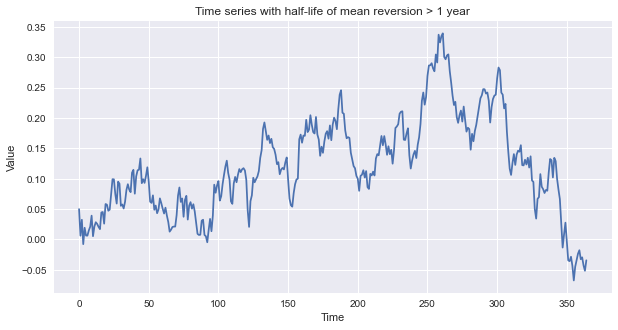

In [60]:
import matplotlib.pyplot as plt

# Generate the time series
length = 365
mu = 0.05
sigma = 0.02
theta = 0.01

ts = generate_time_series(length, mu, sigma, theta)

# Plot the time series
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts)
ax.set_title('Time series with half-life of mean reversion > 1 year')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
plt.show()


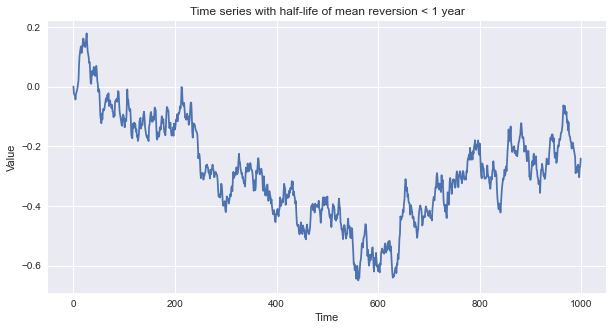

In [86]:
import matplotlib.pyplot as plt

# Generate the time series
length = 1000
mu = 0
sigma = 0.02
theta = 0.00000001

ts = generate_time_series(length, mu, sigma, theta)

# Plot the time series
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts)
ax.set_title('Time series with half-life of mean reversion < 1 year')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
plt.show()


In [76]:
import numpy as np

def generate_stock_spread(length, mu1, sigma1, mu2, sigma2, theta):
    """
    Generates a time series of the spread between two stocks with a half-life of mean reversion greater than one year.
    
    Args:
    - length: the length of the time series to generate
    - mu1: the mean of the random walk with drift for stock 1
    - sigma1: the standard deviation of the random walk with drift for stock 1
    - mu2: the mean of the random walk with drift for stock 2
    - sigma2: the standard deviation of the random walk with drift for stock 2
    - theta: the rate of mean reversion (larger values correspond to slower mean reversion)
    
    Returns:
    - A numpy array containing the generated time series of the stock spread
    """
    # Generate random walks with drift for each stock
    eps1 = np.random.normal(0, 1, length)
    eps2 = np.random.normal(0, 1, length)
    rw1 = np.zeros(length)
    rw2 = np.zeros(length)
    rw1[0] = mu1
    rw2[0] = mu2
    for i in range(1, length):
        rw1[i] = rw1[i-1] + mu1 + sigma1*eps1[i]
        rw2[i] = rw2[i-1] + mu2 + sigma2*eps2[i]
    
    # Compute the spread between the two stocks and apply mean reversion using an Ornstein-Uhlenbeck process
    spread = rw1 - rw2
    ou = np.zeros(length)
    ou[0] = spread[0]
    for i in range(1, length):
        ou[i] = ou[i-1] + theta*(np.mean(spread) - ou[i-1]) + np.sqrt(1-theta**2)*np.std(spread)*eps1[i]
    
    return ou


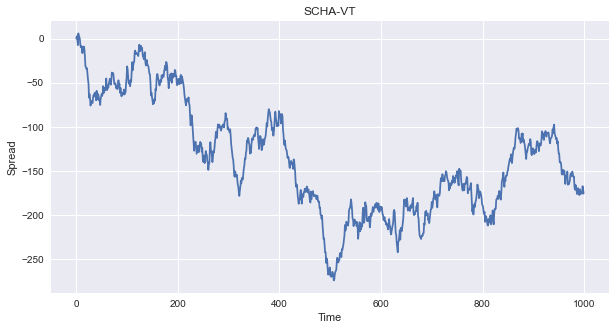

In [77]:
import matplotlib.pyplot as plt

# Generate the time series
length = 1000
mu1 = 0.05
sigma1 = 0.02
mu2 = 0.03
sigma2 = 0.01
theta = 0.001

ts = generate_stock_spread(length, mu1, sigma1, mu2, sigma2, theta)

# Plot the time series
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts)
ax.set_title('SCHA-VT')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
plt.show()


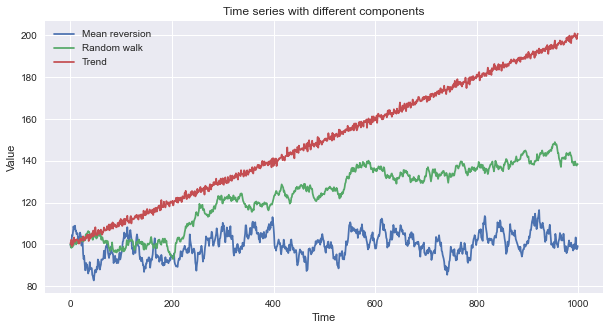

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time series with mean reversion, random walk, and trend components
length = 1000

# Mean reversion
mr = np.zeros(length)
mr[0] = 100
theta = 0.05
mu = 100
sigma = 2
for i in range(1, length):
    mr[i] = mr[i-1] + theta*(mu-mr[i-1]) + sigma*np.random.normal()

# Random walk
rw = np.zeros(length)
rw[0] = 100
for i in range(1, length):
    rw[i] = rw[i-1] + np.random.normal()

# Trend
trend = np.linspace(100, 200, length) + np.random.normal(size=length)

# Plot the time series
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mr, label='Mean reversion')
ax.plot(rw, label='Random walk')
ax.plot(trend, label='Trend')
ax.legend()
ax.set_title('Time series with different components')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
plt.show()


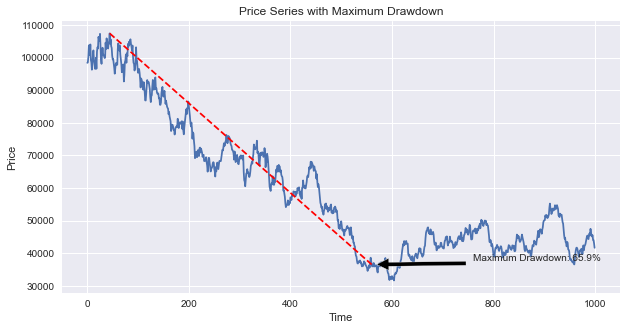

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample price series
length = 1000
prices = np.cumprod(1 + np.random.normal(0, 0.02, length)) * 100000

# Calculate maximum drawdown
peak_index = np.argmax(prices)
trough_index = np.argmin(prices[peak_index:])
max_drawdown = (prices[peak_index] - prices[trough_index]) / prices[peak_index] * 100

# Plot the price series and the maximum drawdown
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(prices)
ax.plot([peak_index, trough_index], [prices[peak_index], prices[trough_index]], 'r--')
ax.annotate(f'Maximum Drawdown: {max_drawdown:.1f}%', 
            xy=(trough_index, prices[trough_index]), 
            xytext=(trough_index+200, prices[trough_index]+1000),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_title('Price Series with Maximum Drawdown')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
plt.show()
